# Importing the Specific Libraries

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"
import glob
import cv2
import matplotlib.pyplot as plt
import numpy as np

# The Metric Implementation

In [ ]:
def TCmetric(depth1, depth2, image1, image2, occlusion_threshold, threshold):
    
    #compute the optical flow
    gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)
    flow = cv2.calcOpticalFlowFarneback(gray1, gray2, None, 0.5, 3, 15, 3, 5, 1.2, 0)
    
    #the depth image is a=in gray scale with one channel and dimentions (256,192), 
    #so we add a dimension to allow it to be broadcasted or used in operations that require an additional dimension.
    depth1 = np.expand_dims(depth1, axis=-1)
    depth2 = np.expand_dims(depth2, axis=-1)

    #applying the optical flow on the 1st predicted image 
    height, width, _ = depth1.shape
    
    y_coords, x_coords = np.indices((height, width), dtype=np.float32)
    dx, dy = flow[..., 0], flow[..., 1]
    map_x = x_coords + dx
    map_y = y_coords + dy
    warped_depth1 = cv2.remap(depth1, map_x, map_y, cv2.INTER_LINEAR)
    
    #calculating the occlusion matrix
    warped_image1 = cv2.remap(image1, map_x, map_y, cv2.INTER_LINEAR)
    #3-channel image, where each pixel represents the absolute difference between the corresponding pixel values in image2 and warped_image1
    color_diff = np.abs(image2 - warped_image1)
    non_occlusion_mask = (color_diff < occlusion_threshold).astype(np.uint8)
    
    #warped_depth2 is with two dimenstions, we added a third one so we can divide it by depth2 that is with 3d.
    warped_depth1 = np.expand_dims(warped_depth1, axis=-1)
    # Compute the ratio of depth change
    ratio_depth_change = np.abs(depth2 / warped_depth1)
    num_valid_pixels = np.sum(non_occlusion_mask)
    
    # Computing the TC metric
    temporal_consistency = np.sum(non_occlusion_mask *(np.maximum(ratio_depth_change, 1/ratio_depth_change) < threshold)) / num_valid_pixels
    return temporal_consistency

# Navigation to the path of the original frames of the videos and the predicted ones

In [5]:
rgbs = []
predictions_model4 = []
predictions_model7 = []

pred_path_model4 =  "/workspace/minimalist_ultradepth/experiment_results/TC004/TC004_movie_indoor_smooth_min_vals/predictions"
pred_path_model7 =  "/workspace/minimalist_ultradepth/experiment_results/TC007/TC007_movie_indoor_smooth_min_vals/predictions"
rgb_path = "/data/data/SceneNet_15x20_bellatola_train_v0_0/movie_indoor_smooth_min_vals/png"
for i in range (1082):
    rgb = cv2.imread(os.path.join(rgb_path, f'{0000+i:04d}', f"color_{0000+i:04d}.png"),-1)
    pred_4 = cv2.imread(os.path.join(pred_path_model4, f'{0000+i:04d}', f"{0000+i:04d}_color_Prediction.png"),-1)
    pred_7 = cv2.imread(os.path.join(pred_path_model7, f'{0000+i:04d}', f"{0000+i:04d}_color_Prediction.png"),-1)
    
    rgbs.append(rgb)
    predictions_model4.append(pred_4)
    predictions_model7.append(pred_7)

# Comparing the Temporal Consistency of videos resulted from Model 4 and Model 7

Calculating the Temporal consistecy of the depth video estimated by model TC_004 (with skip connections) for the range of depths between 0 to 12 meters.

In [81]:
tcs4 = []
for i in range(len(rgbs)-1):
    tc_4 = TCmetric(predictions_model4[i], predictions_model4[i+1], rgbs[i], rgbs[i+1], 20, 1.05)
    tcs4.append(tc_4)
TC_004=sum(tcs4)/len(tcs4)
print(TC_004)

<ipython-input-6-ea8bbe6010a1>:31: RuntimeWarning: divide by zero encountered in true_divide
  ratio_depth_change = np.abs(depth2 / warped_depth1)


0.7952040858502616


Calculating the Temporal consistecy of the depth video estimated by model TC_004 (with skip connections) for the range of depths between 0 to 7 meters.

In [82]:
tcs4_1= []
for i in range(len(rgbs)-1):
    pred_1 = predictions_model4[i]
    pred_1 = np.where(pred_1 < 7000, pred_1, 7000)
    pred_2 = predictions_model4[i+1]
    pred_2 = np.where(pred_2 < 7000, pred_2, 7000)
    tc4_1 = TCmetric(pred_1, pred_2, rgbs[i], rgbs[i+1], 20, 1.05)
    tcs4_1.append(tc4_1)
TC_004_1=sum(tcs4_1)/len(tcs4_1)
print(TC_004_1)

<ipython-input-6-ea8bbe6010a1>:31: RuntimeWarning: divide by zero encountered in true_divide
  ratio_depth_change = np.abs(depth2 / warped_depth1)


0.8211005532784984


Calculating the Temporal consistecy of the depth video estimated by model TC_007 (without skip connections) for the range of depths between 0 to 12 meters.

In [85]:
tcs7 = []
for i in range(len(rgbs)-1):
    tc_7 = TCmetric(predictions_model7[i], predictions_model7[i+1], rgbs[i], rgbs[i+1], 20, 1.05)
    tcs7.append(tc_7)
TC_007=sum(tcs7)/len(tcs7)
print(TC_model7)

<ipython-input-6-ea8bbe6010a1>:31: RuntimeWarning: divide by zero encountered in true_divide
  ratio_depth_change = np.abs(depth2 / warped_depth1)


0.8257454940951701


Calculating the Temporal consistecy of the depth video estimated by model TC_007 (without skip connections) for the range of depths between 0 to 7 meters.

In [86]:
tcs7_1 = []
for i in range(len(rgbs)-1):
    pred_1 = predictions_model7[i]
    pred_1 = np.where(pred_1 < 7000, pred_1, 7000)
    pred_2 = predictions_model7[i+1]
    pred_2 = np.where(pred_2 < 7000, pred_2, 7000)
    tc7_1 = TCmetric(pred_1, pred_2, rgbs[i], rgbs[i+1], 20, 1.05)
    tcs7_1.append(tc7_1)
TC_007_1=sum(tcs7_1)/len(tcs7_1)
print(TC_007_1)

<ipython-input-6-ea8bbe6010a1>:31: RuntimeWarning: divide by zero encountered in true_divide
  ratio_depth_change = np.abs(depth2 / warped_depth1)


0.8257454940951701


In [95]:
np.median(tcs4), np.median(tcs4_1)

(0.8234215352370972, 0.8541136679000925)

In [96]:
np.median(tcs7), np.median(tcs7_1)

(0.8708500874452533, 0.8708500874452533)

Histograms of the distribution of TCs

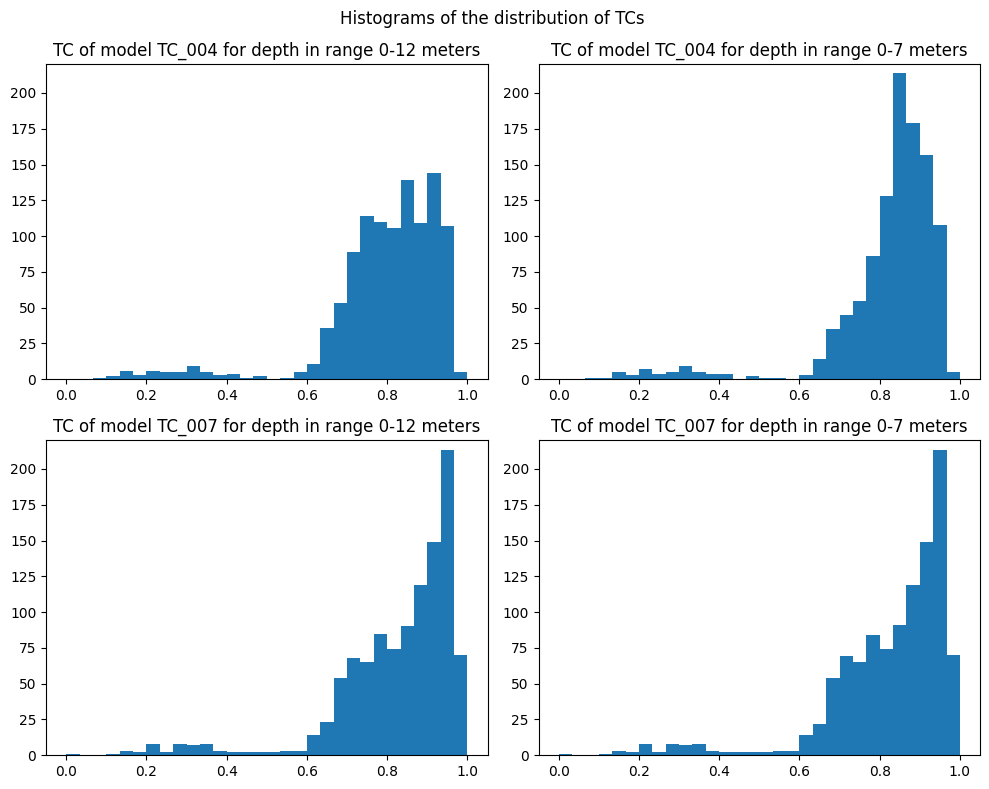

In [112]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
fig.suptitle('Histograms of the distribution of TCs ')


axs[0, 0].hist(tcs4, bins = 30, range= (0,1))
axs[0, 0].set_title('TC of model TC_004 for depth in range 0-12 meters')
axs[0, 0].set_ylim([0, 220])
axs[0, 1].hist(tcs4_1, bins = 30, range= (0,1))
axs[0, 1].set_title('TC of model TC_004 for depth in range 0-7 meters')
axs[0, 1].set_ylim([0, 220])
axs[1, 0].hist(tcs7, bins = 30, range= (0,1))
axs[1, 0].set_title('TC of model TC_007 for depth in range 0-12 meters')
axs[1, 0].set_ylim([0, 220])
axs[1, 1].hist(tcs7_1, bins = 30, range= (0,1))
axs[1, 1].set_title('TC of model TC_007 for depth in range 0-7 meters')
axs[1, 1].set_ylim([0, 220])

plt.tight_layout()

plt.show()

# Examples of TC between Random Choosen Images

1- Loading the images

In [23]:
prediction1 = cv2.imread("/workspace/minimalist_ultradepth/experiment_results/TC004/TC004_movie_indoor_smooth_min_vals/predictions/0100/0100_color_Prediction.png",-1)
prediction2 = cv2.imread("/workspace/minimalist_ultradepth/experiment_results/TC004/TC004_movie_indoor_smooth_min_vals/predictions/0101/0101_color_Prediction.png",-1)
rgb1 = cv2.imread("/data/data/SceneNet_15x20_bellatola_train_v0_0/movie_indoor_smooth_min_vals/png/0100/color_0100.png", -1)[...,::-1]
rgb2 = cv2.imread("/data/data/SceneNet_15x20_bellatola_train_v0_0/movie_indoor_smooth_min_vals/png/0101/color_0101.png", -1)[...,::-1]

In [20]:
prediction3 = cv2.imread("/workspace/minimalist_ultradepth/experiment_results/TC004/TC004_movie_indoor_smooth_min_vals/predictions/0500/0500_color_Prediction.png",-1)
prediction4 = cv2.imread("/workspace/minimalist_ultradepth/experiment_results/TC004/TC004_movie_indoor_smooth_min_vals/predictions/0501/0501_color_Prediction.png",-1)
rgb3 = cv2.imread("/data/data/SceneNet_15x20_bellatola_train_v0_0/movie_indoor_smooth_min_vals/png/0500/color_0500.png", -1)[...,::-1]
rgb4 = cv2.imread("/data/data/SceneNet_15x20_bellatola_train_v0_0/movie_indoor_smooth_min_vals/png/0501/color_0501.png", -1)[...,::-1]

In [32]:
prediction5 = cv2.imread("/workspace/minimalist_ultradepth/experiment_results/TC004/TC004_movie_indoor_smooth_min_vals/predictions/0010/0010_color_Prediction.png",-1)
prediction6 = cv2.imread("/workspace/minimalist_ultradepth/experiment_results/TC004/TC004_movie_indoor_smooth_min_vals/predictions/0011/0011_color_Prediction.png",-1)
rgb5 = cv2.imread("/data/data/SceneNet_15x20_bellatola_train_v0_0/movie_indoor_smooth_min_vals/png/0010/color_0010.png", -1)[...,::-1]
rgb6 = cv2.imread("/data/data/SceneNet_15x20_bellatola_train_v0_0/movie_indoor_smooth_min_vals/png/0011/color_0011.png", -1)[...,::-1]

1- Plotting them

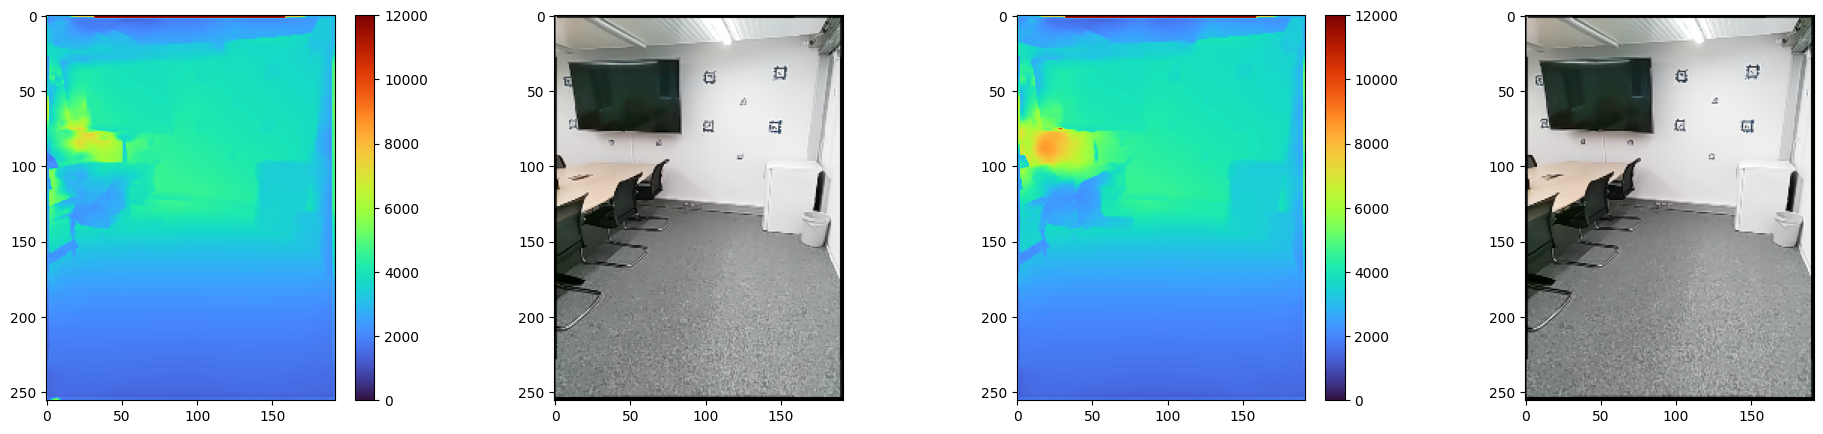

In [55]:
plt.figure(figsize=(24, 5))

max_val = max(prediction1.max(), prediction2.max())
plt.subplot(141)
bar = plt.imshow(prediction1, cmap='turbo', vmin = 0, vmax= max_val)
plt.colorbar(bar)
plt.subplot(142)

plt.imshow(rgb1)

plt.subplot(143)
bar = plt.imshow(prediction2, cmap='turbo',  vmin = 0, vmax= max_val)
plt.colorbar(bar)
plt.subplot(144)

plt.imshow(rgb2)
plt.show()

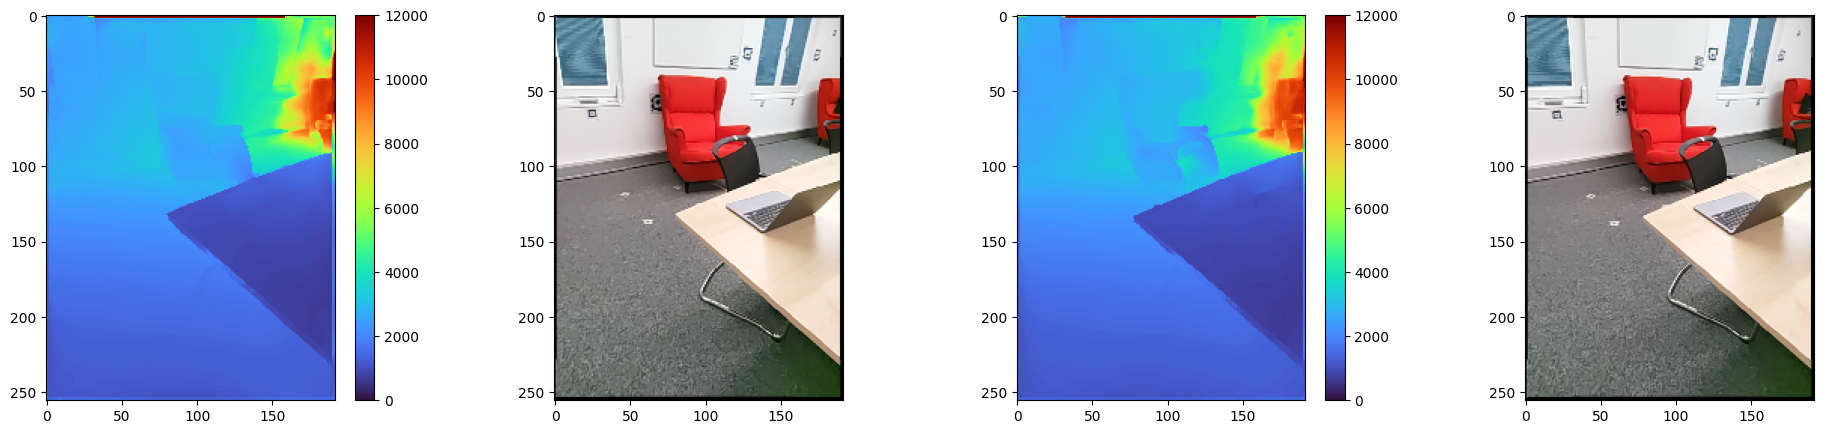

In [66]:
plt.figure(figsize=(24, 5))

max_val = max(prediction3.max(), prediction4.max())
plt.subplot(141)
bar = plt.imshow(prediction3, cmap='turbo', vmin = 0, vmax= max_val)
plt.colorbar(bar)
plt.subplot(142)

plt.imshow(rgb3)

plt.subplot(143)
bar = plt.imshow(prediction4, cmap='turbo',  vmin = 0, vmax= max_val)
plt.colorbar(bar)
plt.subplot(144)

plt.imshow(rgb4)
plt.show()

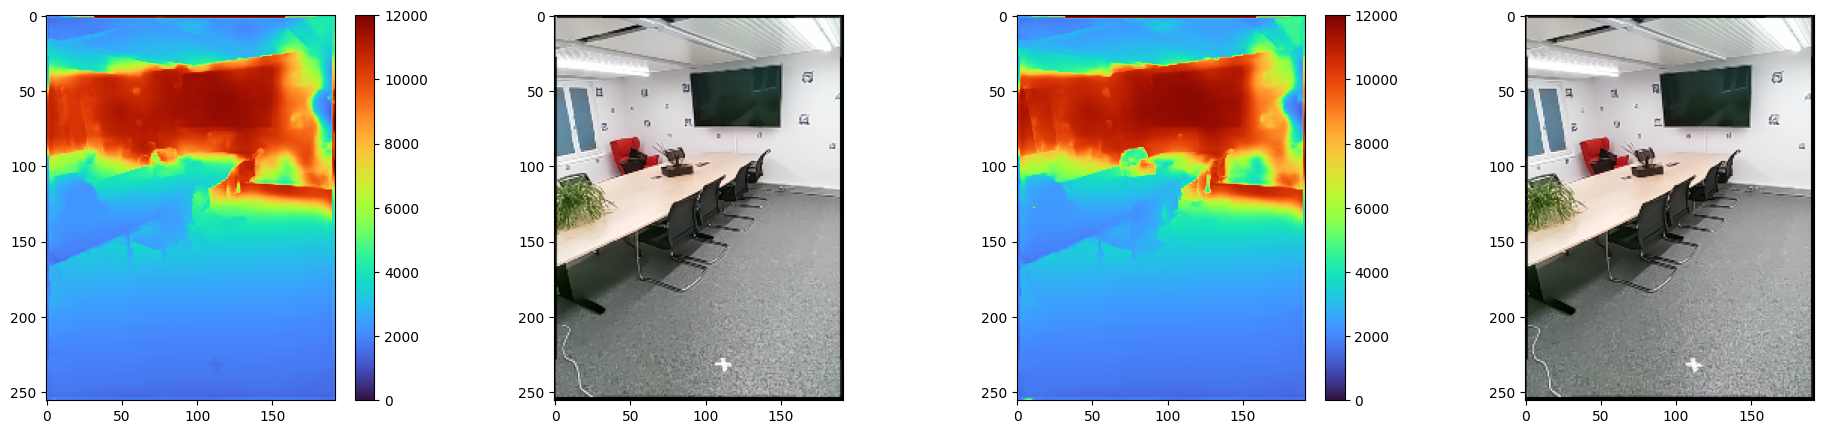

In [106]:
plt.figure(figsize=(24, 5))

max_val = max(prediction5.max(), prediction6.max())
plt.subplot(141)
bar = plt.imshow(prediction5, cmap='turbo', vmin = 0, vmax= max_val)
plt.colorbar(bar)
plt.subplot(142)

plt.imshow(rgb5)

plt.subplot(143)
bar = plt.imshow(prediction6, cmap='turbo',  vmin = 0, vmax= max_val)
plt.colorbar(bar)
plt.subplot(144)

plt.imshow(rgb6)
plt.show()

3-Computing the Temporal consistency between these two frames

In [108]:
TCmetric(prediction1, prediction2, rgb1, rgb2, 20, 1.05)

0.8382229673093042

In [29]:
TCmetric(prediction3, prediction4, rgb3, rgb4, 20, 1.05)

<ipython-input-6-ea8bbe6010a1>:31: RuntimeWarning: divide by zero encountered in true_divide
  ratio_depth_change = np.abs(depth2 / warped_depth1)


0.8410951632332224

In [107]:
TCmetric(prediction5, prediction6, rgb5, rgb6, 20, 1.05)

0.7792570524159762